In [1]:
# === CONFIGURATION ===
# Set the pulsar name here
PULSAR_NAME = "J1909-3744"

# Data paths (modify as needed)
DATA_DIR = "/home/mattm/projects/MPTA/partim/production/fifth_pass/tdb"

# Number of timing iterations for benchmarking
N_BENCHMARK_ITERATIONS = 10

In [2]:
# === IMPORTS AND SETUP ===
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np
import jax
import jax.numpy as jnp
import math
import time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any, Optional, Tuple
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import EarthLocation, get_body_barycentric_posvel, solar_system_ephemeris
import matplotlib.pyplot as plt

# PINT
from pint.models import get_model as pint_get_model
from pint.toa import get_TOAs as pint_get_TOAs
from pint.residuals import Residuals

jax.config.update('jax_enable_x64', True)
print(f"JAX {jax.__version__}, Float64: {jax.config.jax_enable_x64}")
print(f"JAX devices: {jax.devices()}")

JAX 0.8.1, Float64: True
JAX devices: [CudaDevice(id=0)]


W1128 17:36:46.101418   43699 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1128 17:36:46.102505   43521 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [3]:
# === CONSTANTS ===
SECS_PER_DAY = 86400.0
C_KM_S = 299792.458
T_SUN_SEC = 4.925490947e-6
AU_KM = 149597870.7
K_DM_SEC = 1.0 / 2.41e-4

# Planetary GM/c^3 (seconds)
T_PLANET = {
    'jupiter': 4.702819050227708e-09,
    'saturn':  1.408128810019423e-09,
    'uranus':  2.150589551363761e-10,
    'neptune': 2.537311999186760e-10,
    'venus':   1.205680558494223e-11,
}

# Observatory coordinates (ITRF, km) - MeerKAT default
OBSERVATORIES = {
    'meerkat': np.array([5109360.133, 2006852.586, -3238948.127]) / 1000,
    'parkes': np.array([-4554231.533, 2816759.046, -3454036.323]) / 1000,
    'gbt': np.array([882589.289, -4924872.368, 3943729.418]) / 1000,
}

# High-precision parameters
HIGH_PRECISION_PARAMS = {'F0', 'F1', 'F2', 'F3', 'PEPOCH', 'TZRMJD', 'POSEPOCH', 'DMEPOCH'}

In [4]:
# === PARAMETER PARSING ===

def parse_par_file(path: Path) -> Dict[str, Any]:
    """Parse tempo2-style .par file with high precision for timing-critical parameters."""
    params = {}
    params_str = {}
    
    with open(path) as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) >= 2:
                key = parts[0].upper()
                value_str = parts[1]
                
                if key in HIGH_PRECISION_PARAMS:
                    params_str[key] = value_str
                    try:
                        params[key] = float(value_str)
                    except ValueError:
                        params[key] = value_str
                else:
                    try:
                        params[key] = float(value_str)
                    except ValueError:
                        params[key] = value_str
    
    params['_high_precision'] = params_str
    return params


def get_longdouble(params: Dict, key: str, default: float = None) -> np.longdouble:
    """Get a parameter as np.longdouble with full precision."""
    hp = params.get('_high_precision', {})
    if key in hp:
        return np.longdouble(hp[key])
    elif key in params:
        return np.longdouble(params[key])
    elif default is not None:
        return np.longdouble(default)
    else:
        raise KeyError(f"Parameter {key} not found")


def parse_ra(ra_str: str) -> float:
    """Parse RA string (HH:MM:SS.sss) to radians."""
    parts = ra_str.split(':')
    h, m, s = float(parts[0]), float(parts[1]), float(parts[2])
    return (h + m/60 + s/3600) * 15 * np.pi / 180


def parse_dec(dec_str: str) -> float:
    """Parse DEC string (DD:MM:SS.sss) to radians."""
    parts = dec_str.split(':')
    sign = -1 if parts[0].startswith('-') else 1
    d, m, s = abs(float(parts[0])), float(parts[1]), float(parts[2])
    return sign * (d + m/60 + s/3600) * np.pi / 180

In [5]:
# === TIM FILE PARSING ===
# Native .tim file parser (replaces PINT for file loading)

from dataclasses import dataclass
from typing import List, Dict

@dataclass
class TOA:
    """Single time-of-arrival measurement."""
    filename: str
    freq_mhz: float
    mjd_utc: float  # Topocentric UTC MJD
    error_us: float
    observatory: str
    flags: Dict[str, str]

def parse_tim_file(path: Path) -> List[TOA]:
    """
    Parse tempo2-style .tim file.
    
    Supports FORMAT 1:
        filename freq(MHz) MJD error(us) observatory [flags...]
    
    Returns list of TOA objects with raw (un-corrected) times.
    """
    toas = []
    
    with open(path) as f:
        for line in f:
            line = line.strip()
            
            # Skip empty lines and comments
            if not line or line.startswith('#'):
                continue
            
            # Skip FORMAT lines
            if line.startswith('FORMAT'):
                continue
            
            # Skip other header lines (C, JUMP, PHASE, etc.)
            if line.startswith(('C ', 'JUMP', 'PHASE', 'MODE', 'INCLUDE')):
                continue
            
            # Parse TOA line
            parts = line.split()
            if len(parts) < 5:
                continue  # Invalid line
            
            # Extract basic fields (FORMAT 1)
            filename = parts[0]
            freq_mhz = float(parts[1])
            mjd_utc = float(parts[2])
            error_us = float(parts[3])
            observatory = parts[4]
            
            # Parse flags (everything after observatory)
            flags = {}
            i = 5
            while i < len(parts):
                if parts[i].startswith('-') and i + 1 < len(parts):
                    flag_name = parts[i][1:]  # Remove leading '-'
                    flag_value = parts[i + 1]
                    flags[flag_name] = flag_value
                    i += 2
                else:
                    i += 1
            
            toas.append(TOA(
                filename=filename,
                freq_mhz=freq_mhz,
                mjd_utc=mjd_utc,
                error_us=error_us,
                observatory=observatory,
                flags=flags
            ))
    
    return toas

print("TIM file parser defined.")

TIM file parser defined.


In [6]:
# === CLOCK CORRECTION SYSTEM ===
# Native clock correction chain (replaces PINT for clock corrections)
# Implements tempo2-style OBS→UTC→GPS/TAI→TT→BIPM chaining

from bisect import bisect_left

# Load observatory aliases
alias_path = Path('data/observatory/tempo.aliases')
alias_map = {}

if alias_path.exists():
    for line in alias_path.read_text().splitlines():
        if not line or line.startswith('#'):
            continue
        parts = line.split()
        if len(parts) >= 2:
            primary = parts[0].lower()
            # Map all aliases to primary name
            for alias in parts[1:]:
                alias_map[alias.lower()] = primary
            # Also map primary to itself
            alias_map[primary] = primary

def _load_clock_edges(clock_dir: Path):
    """
    Load clock correction files and build graph edges.
    
    Clock files are named {src}2{dst}.clk (e.g., mk2utc.clk, utc2tai.clk).
    Each file contains MJD and offset columns for linear interpolation.
    """
    edges = {}
    
    for cf in clock_dir.glob('*.clk'):
        name = cf.stem.lower()
        if '2' not in name:
            continue
        
        # Parse filename to get source and destination time scales
        src, dst = name.split('2', 1)
        
        try:
            data = []
            for line in cf.read_text().splitlines():
                if not line or line.startswith('#'):
                    continue
                parts = line.split()
                if len(parts) < 2:
                    continue
                mjd = float(parts[0])
                offset = float(parts[1])
                data.append((mjd, offset))
            
            if not data:
                continue
            
            data.sort()  # Ensure sorted by MJD for bisect
            edges.setdefault(src, []).append({
                'dst': dst,
                'mjd': [d[0] for d in data],
                'off': [d[1] for d in data]
            })
        except Exception as e:
            print(f"Warning: Failed to load {cf.name}: {e}")
            continue
    
    return edges

def _interp_offset(series, mjd):
    """Linear interpolation of clock offset at given MJD."""
    mjds = series['mjd']
    offs = series['off']
    
    idx = bisect_left(mjds, mjd)
    
    # Extrapolate using edge values
    if idx == 0:
        return offs[0]
    if idx >= len(mjds):
        return offs[-1]
    
    # Linear interpolation
    t0, t1 = mjds[idx-1], mjds[idx]
    o0, o1 = offs[idx-1], offs[idx]
    
    if t1 == t0:
        return o0
    
    w = (mjd - t0) / (t1 - t0)
    return o0 + w * (o1 - o0)

def _choose_tai2tt(edges, bipm_version=None):
    """
    Select TAI→TT conversion file.
    
    Prefer the most recent BIPM file, or match the requested version.
    """
    candidates = edges.get('tai', [])
    
    if not candidates:
        return None
    
    # If specific BIPM version requested, try to find it
    if bipm_version:
        target = f"tt_bipm{bipm_version}".lower()
        for c in candidates:
            if target in c['dst'].lower():
                return c
    
    # Otherwise pick most recent BIPM year
    best = None
    best_year = -1
    
    for c in candidates:
        dst = c['dst']
        if dst.startswith('tt'):
            try:
                # Extract year from filenames like tt_bipm2024, tt_bipm2023, etc.
                year_str = dst.split('_')[-1].replace('bipm', '').replace('.clk', '')
                year = int(year_str[:4]) if year_str else -1
            except Exception:
                year = -1
            
            if year > best_year:
                best_year = year
                best = c
    
    return best or candidates[0]

def _clock_sources_for_obs(obs_code: str, alias_map: Dict[str, str]) -> List[str]:
    """
    Resolve observatory code to potential clock source names.
    
    Follows tempo2-style alias resolution: try full name, base name,
    2-char prefix, 3-char prefix, etc.
    """
    code_lower = obs_code.lower()
    out = []
    
    # Get base name from alias map
    base = alias_map.get(code_lower, code_lower)
    
    # Include all alias tokens that map to the same base
    alias_tokens = [k for k, v in alias_map.items() if v == base]
    out.extend(alias_tokens)
    
    # Add various length prefixes
    out.append(base)
    out.append(base[:2])
    out.append(base[:3])
    out.append(code_lower)
    
    # Remove duplicates while preserving order
    return list(dict.fromkeys([s for s in out if s]))

def clock_correction_seconds(mjd_utc: float, obs_code: str, clock_edges: Dict, 
                              tai2tt_edge: Dict, alias_map: Dict[str, str]) -> float:
    """
    Compute total clock correction for a TOA.
    
    Walks the chain: OBS → UTC → GPS/TAI → TT (BIPM)
    Returns total correction in seconds.
    """
    src_candidates = _clock_sources_for_obs(obs_code, alias_map)
    
    for src in src_candidates:
        cur = src
        total = 0.0
        visited = set()
        
        while True:
            if cur in visited:
                break  # Avoid infinite loops
            visited.add(cur)
            
            # Get all edges from current node
            edges = clock_edges.get(cur, [])
            if not edges:
                break
            
            # Prefer standard time scales in order: utc, gps, tai, tt
            preferred_order = ['utc', 'gps', 'tai', 'tt']
            edges_sorted = sorted(edges, key=lambda e: 
                preferred_order.index(e['dst']) if e['dst'] in preferred_order else 99
            )
            
            edge = edges_sorted[0]
            offset = _interp_offset(edge, mjd_utc)
            total += offset
            cur = edge['dst']
            
            # Terminal conditions
            if cur in ('tt', 'tai'):
                if cur == 'tai' and tai2tt_edge:
                    # Apply final TAI→TT conversion
                    total += _interp_offset(tai2tt_edge, mjd_utc)
                return total
            
            # Continue walking chain for intermediate time scales
            if cur in ('utc', 'gps'):
                continue
        
        # If we successfully walked to a terminal node, return
        if total != 0.0:
            return total
    
    # No valid chain found - return 0 (no correction)
    return 0.0

# Build clock correction graph
clock_dir = Path('data/clock')
clock_edges = {}
tai2tt_edge = None

if clock_dir.exists():
    clock_edges = _load_clock_edges(clock_dir)
    
    # Determine BIPM version from .par file if available
    # (Will be set when we parse the .par file)
    tai2tt_edge = _choose_tai2tt(clock_edges, bipm_version=None)
    
    print(f"Loaded clock correction graph: {len(clock_edges)} source nodes")
    print(f"TAI→TT edge: {tai2tt_edge['dst'] if tai2tt_edge else 'None'}")
else:
    print(f"Warning: Clock directory {clock_dir} not found")

print("Clock correction system initialized.")

Loaded clock correction graph: 34 source nodes
TAI→TT edge: tt_bipm2024
Clock correction system initialized.


In [7]:
# === ASTROMETRIC AND DELAY FUNCTIONS ===

def compute_ssb_obs_pos_vel(tdb_mjd: np.ndarray, obs_itrf_km: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Compute observatory position and velocity relative to SSB using Astropy/DE440."""
    times = Time(tdb_mjd, format='mjd', scale='tdb')
    
    with solar_system_ephemeris.set('de440'):
        earth_pv = get_body_barycentric_posvel('earth', times)
        ssb_geo_pos = earth_pv[0].xyz.to(u.km).value.T
        ssb_geo_vel = earth_pv[1].xyz.to(u.km/u.s).value.T
    
    obs_itrf = EarthLocation.from_geocentric(
        obs_itrf_km[0] * u.km, obs_itrf_km[1] * u.km, obs_itrf_km[2] * u.km
    )
    
    obs_gcrs = obs_itrf.get_gcrs(obstime=times)
    geo_obs_pos = np.column_stack([
        obs_gcrs.cartesian.x.to(u.km).value,
        obs_gcrs.cartesian.y.to(u.km).value,
        obs_gcrs.cartesian.z.to(u.km).value
    ])
    
    # Observatory velocity from numerical derivative
    dt_sec = 1.0
    times_plus = Time(tdb_mjd + dt_sec/SECS_PER_DAY, format='mjd', scale='tdb')
    obs_gcrs_plus = obs_itrf.get_gcrs(obstime=times_plus)
    geo_obs_pos_plus = np.column_stack([
        obs_gcrs_plus.cartesian.x.to(u.km).value,
        obs_gcrs_plus.cartesian.y.to(u.km).value,
        obs_gcrs_plus.cartesian.z.to(u.km).value
    ])
    geo_obs_vel = (geo_obs_pos_plus - geo_obs_pos) / dt_sec
    
    return ssb_geo_pos + geo_obs_pos, ssb_geo_vel + geo_obs_vel


def compute_pulsar_direction(ra_rad: float, dec_rad: float, pmra_rad_day: float, 
                              pmdec_rad_day: float, posepoch: float, t_mjd: np.ndarray) -> np.ndarray:
    """Compute pulsar direction unit vector with proper motion."""
    dt = t_mjd - posepoch
    cos_dec0 = np.cos(dec_rad)
    ra = ra_rad + pmra_rad_day * dt / cos_dec0
    dec = dec_rad + pmdec_rad_day * dt
    cos_dec = np.cos(dec)
    return np.column_stack([cos_dec * np.cos(ra), cos_dec * np.sin(ra), np.sin(dec)])


def compute_roemer_delay(ssb_obs_pos_km: np.ndarray, L_hat: np.ndarray, 
                         parallax_mas: float = 0.0) -> np.ndarray:
    """Compute Roemer delay including parallax correction."""
    re_dot_L = np.sum(ssb_obs_pos_km * L_hat, axis=1)
    roemer_sec = -re_dot_L / C_KM_S
    
    if parallax_mas != 0.0:
        distance_kpc = 1.0 / parallax_mas
        L_km = distance_kpc * 3.085677581e16
        re_sqr = np.sum(ssb_obs_pos_km**2, axis=1)
        parallax_sec = 0.5 * (re_sqr / L_km) * (1.0 - re_dot_L**2 / re_sqr) / C_KM_S
        roemer_sec = roemer_sec + parallax_sec
    return roemer_sec


def compute_shapiro_delay(obs_body_pos_km: np.ndarray, L_hat: np.ndarray, 
                          T_body: float) -> np.ndarray:
    """Compute Shapiro delay for a body."""
    r = np.sqrt(np.sum(obs_body_pos_km**2, axis=1))
    rcostheta = np.sum(obs_body_pos_km * L_hat, axis=1)
    return -2.0 * T_body * np.log((r - rcostheta) / AU_KM)


def compute_barycentric_freq(freq_topo_mhz: np.ndarray, ssb_obs_vel_km_s: np.ndarray, 
                              L_hat: np.ndarray) -> np.ndarray:
    """Compute barycentric frequency."""
    v_radial = np.sum(ssb_obs_vel_km_s * L_hat, axis=1)
    return freq_topo_mhz * (1.0 - v_radial / C_KM_S)

In [8]:
# === FURTHER OPTIMIZATION: COMBINED JAX DELAY FUNCTION ===
# Combine DM, solar wind, FD, and binary delays into a single JIT function
# This avoids multiple np.array() conversions which are expensive

@jax.jit
def combined_delays(tdbld, freq_bary, obs_sun_pos, L_hat,
                    dm_coeffs, dm_factorials, dm_epoch,
                    ne_sw, fd_coeffs, has_fd,
                    roemer_shapiro, has_binary,
                    pb, a1, tasc, eps1, eps2, pbdot, xdot, gamma, r_shap, s_shap):
    """Combined delay calculation - single JAX kernel."""
    
    # DM delay
    dt_years = (tdbld - dm_epoch) / 365.25
    powers = jnp.arange(len(dm_coeffs))
    dt_powers = dt_years[:, jnp.newaxis] ** powers[jnp.newaxis, :]
    dm_eff = jnp.sum(dm_coeffs * dt_powers / dm_factorials, axis=1)
    dm_sec = K_DM_SEC * dm_eff / (freq_bary ** 2)
    
    # Solar wind delay
    AU_KM_local = 1.495978707e8
    AU_PC = 4.84813681e-6
    r_km = jnp.sqrt(jnp.sum(obs_sun_pos**2, axis=1))
    r_au = r_km / AU_KM_local
    sun_dir = obs_sun_pos / r_km[:, jnp.newaxis]
    cos_elong = jnp.sum(sun_dir * L_hat, axis=1)
    elong = jnp.arccos(jnp.clip(cos_elong, -1.0, 1.0))
    rho = jnp.pi - elong
    sin_rho = jnp.maximum(jnp.sin(rho), 1e-10)
    geometry_pc = AU_PC * rho / (r_au * sin_rho)
    dm_sw = ne_sw * geometry_pc
    sw_sec = jnp.where(ne_sw > 0, K_DM_SEC * dm_sw / (freq_bary ** 2), 0.0)
    
    # FD delay
    log_freq = jnp.log(freq_bary / 1000.0)
    fd_sec = jnp.where(
        has_fd,
        jnp.polyval(jnp.concatenate([fd_coeffs[::-1], jnp.array([0.0])]), log_freq),
        0.0
    )
    
    # Binary delay (only if has_binary)
    def compute_binary(args):
        tdbld, roemer_shapiro, dm_sec, sw_sec, fd_sec = args
        t_topo_tdb = tdbld - (roemer_shapiro + dm_sec + sw_sec + fd_sec) / SECS_PER_DAY
        dt_days = t_topo_tdb - tasc
        dt_sec_bin = dt_days * SECS_PER_DAY
        n0 = 2.0 * jnp.pi / (pb * SECS_PER_DAY)
        Phi = n0 * dt_sec_bin * (1.0 - pbdot / 2.0 / pb * dt_days)
        
        sin_Phi, cos_Phi = jnp.sin(Phi), jnp.cos(Phi)
        sin_2Phi, cos_2Phi = jnp.sin(2*Phi), jnp.cos(2*Phi)
        sin_3Phi, cos_3Phi = jnp.sin(3*Phi), jnp.cos(3*Phi)
        sin_4Phi, cos_4Phi = jnp.sin(4*Phi), jnp.cos(4*Phi)
        
        a1_eff = jnp.where(xdot != 0.0, a1 + xdot * dt_sec_bin, a1)
        
        eps1_sq, eps2_sq = eps1**2, eps2**2
        eps1_cu, eps2_cu = eps1**3, eps2**3
        
        Dre_a1 = (
            sin_Phi + 0.5 * (eps2 * sin_2Phi - eps1 * cos_2Phi)
            - (1.0/8.0) * (5*eps2_sq*sin_Phi - 3*eps2_sq*sin_3Phi - 2*eps2*eps1*cos_Phi
                          + 6*eps2*eps1*cos_3Phi + 3*eps1_sq*sin_Phi + 3*eps1_sq*sin_3Phi)
            - (1.0/12.0) * (5*eps2_cu*sin_2Phi + 3*eps1_sq*eps2*sin_2Phi
                           - 6*eps1*eps2_sq*cos_2Phi - 4*eps1_cu*cos_2Phi
                           - 4*eps2_cu*sin_4Phi + 12*eps1_sq*eps2*sin_4Phi
                           + 12*eps1*eps2_sq*cos_4Phi - 4*eps1_cu*cos_4Phi)
        )
        
        Drep_a1 = (
            cos_Phi + eps1 * sin_2Phi + eps2 * cos_2Phi
            - (1.0/8.0) * (5*eps2_sq*cos_Phi - 9*eps2_sq*cos_3Phi + 2*eps1*eps2*sin_Phi
                          - 18*eps1*eps2*sin_3Phi + 3*eps1_sq*cos_Phi + 9*eps1_sq*cos_3Phi)
            - (1.0/12.0) * (10*eps2_cu*cos_2Phi + 6*eps1_sq*eps2*cos_2Phi
                           + 12*eps1*eps2_sq*sin_2Phi + 8*eps1_cu*sin_2Phi
                           - 16*eps2_cu*cos_4Phi + 48*eps1_sq*eps2*cos_4Phi
                           - 48*eps1*eps2_sq*sin_4Phi + 16*eps1_cu*sin_4Phi)
        )
        
        Drepp_a1 = (
            -sin_Phi + 2*eps1*cos_2Phi - 2*eps2*sin_2Phi
            - (1.0/8.0) * (-5*eps2_sq*sin_Phi + 27*eps2_sq*sin_3Phi + 2*eps1*eps2*cos_Phi
                          - 54*eps1*eps2*cos_3Phi - 3*eps1_sq*sin_Phi - 27*eps1_sq*sin_3Phi)
            - (1.0/12.0) * (-20*eps2_cu*sin_2Phi - 12*eps1_sq*eps2*sin_2Phi
                           + 24*eps1*eps2_sq*cos_2Phi + 16*eps1_cu*cos_2Phi
                           + 64*eps2_cu*sin_4Phi - 192*eps1_sq*eps2*sin_4Phi
                           - 192*eps1*eps2_sq*cos_4Phi + 64*eps1_cu*cos_4Phi)
        )
        
        Dre = a1_eff * Dre_a1
        Drep = a1_eff * Drep_a1
        Drepp = a1_eff * Drepp_a1
        
        delay_roemer = Dre * (1 - n0*Drep + (n0*Drep)**2 + 0.5*n0**2*Dre*Drepp)
        delay_einstein = gamma * sin_Phi
        delay_shapiro = jnp.where(
            (r_shap != 0.0) & (s_shap != 0.0),
            -2.0 * r_shap * jnp.log(1.0 - s_shap * sin_Phi),
            0.0
        )
        
        return delay_roemer + delay_einstein + delay_shapiro
    
    binary_sec = jnp.where(
        has_binary,
        compute_binary((tdbld, roemer_shapiro, dm_sec, sw_sec, fd_sec)),
        0.0
    )
    
    return dm_sec + sw_sec + fd_sec + binary_sec

print("Combined delay function defined.")

Combined delay function defined.


In [9]:
# === COMPUTE TOTAL DELAY JAX ===
# This function wraps combined_delays and adds roemer_shapiro in a single JAX kernel

@jax.jit
def compute_total_delay_jax(tdbld, freq_bary, obs_sun, L_hat,
                            dm_coeffs, dm_factorials, dm_epoch,
                            ne_sw, fd_coeffs, has_fd,
                            roemer_shapiro, has_binary,
                            pb, a1, tasc, eps1, eps2, pbdot, xdot, gamma, r_shap, s_shap):
    """Compute total delay in a single JAX kernel (roemer_shapiro + combined delays)."""

    combined_sec = combined_delays(
        tdbld, freq_bary, obs_sun, L_hat,
        dm_coeffs, dm_factorials, dm_epoch,
        ne_sw, fd_coeffs, has_fd,
        roemer_shapiro, has_binary,
        pb, a1, tasc, eps1, eps2, pbdot, xdot, gamma, r_shap, s_shap
    )

    return roemer_shapiro + combined_sec

print("compute_total_delay_jax defined (warmup happens during calculator initialization)")


compute_total_delay_jax defined (warmup happens during calculator initialization)


In [10]:
# === ALTERNATIVE OPTIMIZATION: PRE-COMPUTED PHASE ARRAYS ===
# Since Numba requires NumPy <= 1.26 and we have NumPy 2.x,
# let's optimize by pre-computing more during initialization

print("Numba requires NumPy <= 1.26, but we have NumPy 2.x")
print("Using alternative optimization: pre-computed tdbld_sec array")

@dataclass
class JUGResidualCalculatorFinal:
    """Final optimized JUG calculator with pre-computed tdbld_sec."""
    
    par_params: Dict[str, Any]
    pint_model: Any
    pint_toas: Any
    obs_itrf_km: np.ndarray
    
    # JAX arrays (all precomputed)
    tdbld_jax: jnp.ndarray = None
    freq_bary_jax: jnp.ndarray = None
    obs_sun_jax: jnp.ndarray = None
    L_hat_jax: jnp.ndarray = None
    roemer_shapiro_jax: jnp.ndarray = None
    dm_coeffs_jax: jnp.ndarray = None
    dm_factorials_jax: jnp.ndarray = None
    dm_epoch_jax: jnp.ndarray = None
    fd_coeffs_jax: jnp.ndarray = None
    ne_sw_jax: jnp.ndarray = None
    has_fd_jax: jnp.ndarray = None
    has_binary_jax: jnp.ndarray = None
    pb_jax: jnp.ndarray = None
    a1_jax: jnp.ndarray = None
    tasc_jax: jnp.ndarray = None
    eps1_jax: jnp.ndarray = None
    eps2_jax: jnp.ndarray = None
    pbdot_jax: jnp.ndarray = None
    xdot_jax: jnp.ndarray = None
    gamma_jax: jnp.ndarray = None
    r_shap_jax: jnp.ndarray = None
    s_shap_jax: jnp.ndarray = None
    
    # PRE-COMPUTED: tdbld already in seconds (saves one multiplication per TOA)
    tdbld_sec_ld: np.ndarray = None  # tdbld * SECS_PER_DAY as longdouble
    PEPOCH_sec: np.longdouble = None
    F0: np.longdouble = None
    F1_half: np.longdouble = None
    F2_sixth: np.longdouble = None
    tzr_phase: np.longdouble = None
    inv_F0_1e6: np.longdouble = None  # Pre-multiply 1e6/F0
    
    def __post_init__(self):
        self._precompute_all()
    
    def _precompute_all(self):
        """Precompute everything possible."""
        tdbld = np.array(self.pint_toas.table['tdbld'].value, dtype=np.float64)
        freq_mhz = np.array(self.pint_toas.table['freq'].value, dtype=np.float64)
        
        # Astrometric
        ra_rad = parse_ra(self.par_params['RAJ'])
        dec_rad = parse_dec(self.par_params['DECJ'])
        pmra_rad_day = self.par_params.get('PMRA', 0.0) * (np.pi / 180 / 3600000) / 365.25
        pmdec_rad_day = self.par_params.get('PMDEC', 0.0) * (np.pi / 180 / 3600000) / 365.25
        posepoch = self.par_params.get('POSEPOCH', self.par_params['PEPOCH'])
        
        ssb_obs_pos_km, ssb_obs_vel_km_s = compute_ssb_obs_pos_vel(tdbld, self.obs_itrf_km)
        L_hat = compute_pulsar_direction(ra_rad, dec_rad, pmra_rad_day, pmdec_rad_day, posepoch, tdbld)
        freq_bary_mhz = compute_barycentric_freq(freq_mhz, ssb_obs_vel_km_s, L_hat)
        
        times = Time(tdbld, format='mjd', scale='tdb')
        with solar_system_ephemeris.set('de440'):
            sun_pos = get_body_barycentric_posvel('sun', times)[0].xyz.to(u.km).value.T
        obs_sun_pos_km = sun_pos - ssb_obs_pos_km
        
        parallax_mas = self.par_params.get('PX', 0.0)
        roemer_sec = compute_roemer_delay(ssb_obs_pos_km, L_hat, parallax_mas)
        sun_shapiro_sec = compute_shapiro_delay(obs_sun_pos_km, L_hat, T_SUN_SEC)
        
        planet_shapiro_enabled = str(self.par_params.get('PLANET_SHAPIRO', 'N')).upper() in ('Y', 'YES', 'TRUE', '1')
        planet_shapiro_sec = np.zeros(len(tdbld))
        if planet_shapiro_enabled:
            with solar_system_ephemeris.set('de440'):
                for planet in ['jupiter', 'saturn', 'uranus', 'neptune', 'venus']:
                    planet_pos = get_body_barycentric_posvel(planet, times)[0].xyz.to(u.km).value.T
                    obs_planet_km = planet_pos - ssb_obs_pos_km
                    planet_shapiro_sec += compute_shapiro_delay(obs_planet_km, L_hat, T_PLANET[planet])
        
        roemer_shapiro_np = roemer_sec + sun_shapiro_sec + planet_shapiro_sec
        
        # JAX arrays
        self.tdbld_jax = jnp.array(tdbld)
        self.freq_bary_jax = jnp.array(freq_bary_mhz)
        self.obs_sun_jax = jnp.array(obs_sun_pos_km)
        self.L_hat_jax = jnp.array(L_hat)
        self.roemer_shapiro_jax = jnp.array(roemer_shapiro_np)
        
        # DM
        dm_coeffs = []
        k = 0
        while True:
            key = 'DM' if k == 0 else f'DM{k}'
            if key in self.par_params:
                dm_coeffs.append(float(self.par_params[key]))
                k += 1
            else:
                break
        dm_coeffs = np.array(dm_coeffs if dm_coeffs else [0.0])
        self.dm_coeffs_jax = jnp.array(dm_coeffs)
        self.dm_factorials_jax = jnp.array([float(math.factorial(i)) for i in range(len(dm_coeffs))])
        self.dm_epoch_jax = jnp.array(float(self.par_params.get('DMEPOCH', self.par_params['PEPOCH'])))
        
        # FD
        fd_coeffs = []
        fd_idx = 1
        while f'FD{fd_idx}' in self.par_params:
            fd_coeffs.append(float(self.par_params[f'FD{fd_idx}']))
            fd_idx += 1
        self.fd_coeffs_jax = jnp.array(fd_coeffs) if fd_coeffs else jnp.array([0.0])
        self.has_fd_jax = jnp.array(len(fd_coeffs) > 0)
        self.ne_sw_jax = jnp.array(float(self.par_params.get('NE_SW', 0.0)))
        
        # Binary
        has_binary = 'PB' in self.par_params
        self.has_binary_jax = jnp.array(has_binary)
        if has_binary:
            self.pb_jax = jnp.array(float(self.par_params['PB']))
            self.a1_jax = jnp.array(float(self.par_params['A1']))
            self.tasc_jax = jnp.array(float(self.par_params['TASC']))
            self.eps1_jax = jnp.array(float(self.par_params.get('EPS1', 0.0)))
            self.eps2_jax = jnp.array(float(self.par_params.get('EPS2', 0.0)))
            self.pbdot_jax = jnp.array(float(self.par_params.get('PBDOT', 0.0)))
            self.xdot_jax = jnp.array(float(self.par_params.get('XDOT', 0.0)))
            self.gamma_jax = jnp.array(float(self.par_params.get('GAMMA', 0.0)))
            M2 = float(self.par_params.get('M2', 0.0))
            SINI = float(self.par_params.get('SINI', 0.0))
            H3 = float(self.par_params.get('H3', 0.0))
            STIG = float(self.par_params.get('STIG', 0.0))
            if H3 != 0.0 or STIG != 0.0:
                self.r_shap_jax, self.s_shap_jax = jnp.array(H3), jnp.array(STIG)
            elif M2 != 0.0 and SINI != 0.0:
                self.r_shap_jax, self.s_shap_jax = jnp.array(T_SUN_SEC * M2), jnp.array(SINI)
            else:
                self.r_shap_jax, self.s_shap_jax = jnp.array(0.0), jnp.array(0.0)
        else:
            for attr in ['pb_jax', 'a1_jax', 'tasc_jax', 'eps1_jax', 'eps2_jax', 
                         'pbdot_jax', 'xdot_jax', 'gamma_jax', 'r_shap_jax', 's_shap_jax']:
                setattr(self, attr, jnp.array(0.0))
        
        # Phase - PRE-COMPUTE tdbld_sec to avoid multiplication in hot path
        PEPOCH = get_longdouble(self.par_params, 'PEPOCH')
        self.F0 = get_longdouble(self.par_params, 'F0')
        F1 = get_longdouble(self.par_params, 'F1', 0.0)
        F2 = get_longdouble(self.par_params, 'F2', 0.0)
        
        self.PEPOCH_sec = PEPOCH * np.longdouble(SECS_PER_DAY)
        self.F1_half = np.longdouble(0.5) * F1
        self.F2_sixth = F2 / np.longdouble(6.0)
        self.inv_F0_1e6 = np.longdouble(1e6) / self.F0  # Combine division and multiply
        
        # PRE-COMPUTE tdbld * SECS_PER_DAY (saves N multiplications per call!)
        tdbld_ld = np.array(self.pint_toas.table['tdbld'].value, dtype=np.longdouble)
        self.tdbld_sec_ld = tdbld_ld * np.longdouble(SECS_PER_DAY)
        
        # TZR
        pint_tzr_toa = self.pint_model.get_TZR_toa(self.pint_toas)
        TZRMJD_TDB = np.longdouble(pint_tzr_toa.table['tdbld'][0])
        pint_tzr_delay = float(self.pint_model.delay(pint_tzr_toa).to('s').value[0])
        tzr_dt_sec = TZRMJD_TDB * np.longdouble(SECS_PER_DAY) - self.PEPOCH_sec - np.longdouble(pint_tzr_delay)
        self.tzr_phase = self.F0 * tzr_dt_sec + self.F1_half * tzr_dt_sec**2 + self.F2_sixth * tzr_dt_sec**3
        
        # Warmup
        _ = compute_total_delay_jax(
            self.tdbld_jax, self.freq_bary_jax, self.obs_sun_jax, self.L_hat_jax,
            self.dm_coeffs_jax, self.dm_factorials_jax, self.dm_epoch_jax,
            self.ne_sw_jax, self.fd_coeffs_jax, self.has_fd_jax,
            self.roemer_shapiro_jax, self.has_binary_jax,
            self.pb_jax, self.a1_jax, self.tasc_jax, self.eps1_jax, self.eps2_jax,
            self.pbdot_jax, self.xdot_jax, self.gamma_jax, self.r_shap_jax, self.s_shap_jax
        ).block_until_ready()
    
    def compute_residuals(self, verbose: bool = False) -> np.ndarray:
        """Compute residuals (final optimized version)."""
        
        # Single JAX call
        total_delay_jax = compute_total_delay_jax(
            self.tdbld_jax, self.freq_bary_jax, self.obs_sun_jax, self.L_hat_jax,
            self.dm_coeffs_jax, self.dm_factorials_jax, self.dm_epoch_jax,
            self.ne_sw_jax, self.fd_coeffs_jax, self.has_fd_jax,
            self.roemer_shapiro_jax, self.has_binary_jax,
            self.pb_jax, self.a1_jax, self.tasc_jax, self.eps1_jax, self.eps2_jax,
            self.pbdot_jax, self.xdot_jax, self.gamma_jax, self.r_shap_jax, self.s_shap_jax
        ).block_until_ready()
        
        # Convert once
        delay_ld = np.asarray(total_delay_jax, dtype=np.longdouble)
        
        # Optimized phase: tdbld_sec_ld is pre-computed!
        dt_sec = self.tdbld_sec_ld - self.PEPOCH_sec - delay_ld
        
        # Use Horner's method for polynomial: F0*dt + F1_half*dt^2 + F2_sixth*dt^3
        # = dt * (F0 + dt * (F1_half + dt * F2_sixth))
        phase = dt_sec * (self.F0 + dt_sec * (self.F1_half + dt_sec * self.F2_sixth))
        
        # Wrap and convert
        frac_phase = np.mod(phase - self.tzr_phase + 0.5, 1.0) - 0.5
        residuals_us = np.asarray(frac_phase * self.inv_F0_1e6, dtype=np.float64)
        
        if verbose:
            print(f"JUG residuals RMS: {np.std(residuals_us):.3f} µs")
        
        return residuals_us

print("Final optimized calculator defined.")

Numba requires NumPy <= 1.26, but we have NumPy 2.x
Using alternative optimization: pre-computed tdbld_sec array
Final optimized calculator defined.


In [11]:
# === LOAD DATA ===
par_file = Path(DATA_DIR) / f"{PULSAR_NAME}_tdb.par"
tim_file = Path(DATA_DIR) / f"{PULSAR_NAME}.tim"

pint_model = pint_get_model(str(par_file))
pint_toas = pint_get_TOAs(str(tim_file), model=pint_model)
print(f"Loaded {pint_toas.ntoas} TOAs for {pint_model.PSR.value}")

par_params = parse_par_file(par_file)
obs_itrf_km = OBSERVATORIES.get('meerkat')


/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'EPHVER 5'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'TNSUBTRACTPOLY 1'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
/home/mattm/soft/PINT/src/pint/models/model_builder.py:220: UserWarning: Unrecognized parfile line 'DM_SERIES TAYLOR'
  warnings.warn(f"Unrecognized parfile line '{p_line}'", UserWarning)
2025-11-28 17:36:46.651 | DEBUG    | pint.toa:get_TOAs:195 - Using EPHEM = DE440 from the given model
2025-11-28 17:36:46.652 | DEBUG    | pint.toa:get_TOAs:211 - Using CLOCK = BIPM2024 from the given model
2025-11-28 17:36:46.652 | DEBUG    | pint.toa:get_TOAs:232 - Using PLANET_SHAPIRO = True from the given model


2025-11-28 17:36:47.740 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 17:36:47.749 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 17:36:47.963 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 17:36:47.964 | DEBUG    | pint.observatory:_load_gps_clock:108 - Loading global GPS clock file
2025-11-28 17:36:47.965 | DEBUG    | pint.observatory.clock_file:__init__:812 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-11-28 17:36:47.966 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:463 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/home/mattm/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2025-11-28 17:36:47.974 | INFO     | pint.observatory:find_clock_file:9

Loaded 10408 TOAs for J1909-3744


In [12]:
# === INITIALIZE JUG CALCULATOR ===
print("Initializing JUG calculator (precomputing astrometry)...")
t_start = time.perf_counter()

jug_calc = JUGResidualCalculatorFinal(
    par_params=par_params,
    pint_model=pint_model,
    pint_toas=pint_toas,
    obs_itrf_km=obs_itrf_km
)

print(f"JUG initialization time: {time.perf_counter() - t_start:.3f} s")


Initializing JUG calculator (precomputing astrometry)...


2025-11-28 17:36:50.855 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:101 - Creating and dealing with the single TZR_toa for absolute phase
2025-11-28 17:36:50.856 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-11-28 17:36:50.856 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2025-11-28 17:36:50.857 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-11-28 17:36:50.858 | INFO     | pint.observatory:bipm_correction:245 - Applying TT(TAI) to TT(BIPM2023) clock correction (~27 us)
2025-11-28 17:36:50.859 | INFO     | pint.observatory:_load_bipm_clock:119 - Loading BIPM clock version bipm2023
2025-11-28 17:36:50.860 | DEBUG    | pint.observatory.clock_file:__init__:812 - Global clock file tai2tt_bipm2023.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2025-11-28 17:36:50.861 | DEBUG    | pint.observatory.

JUG initialization time: 1.443 s


PERFORMANCE BENCHMARK

Computing PINT residuals...

Benchmarking JUG (200 iterations)...
Benchmarking PINT (10 iterations)...

TIMING RESULTS
JUG:   0.783 ± 0.255 ms (best: 0.448 ms)
PINT:  791.9 ±  36.3 ms (best: 771.4 ms)

Speedup: 1012x faster than PINT
Throughput: 1278 calculations/second

ACCURACY VALIDATION

Residual difference (JUG - PINT):
  Mean:  -6.062 ns
  RMS:    2.551 ns
  Max:    8.179 ns


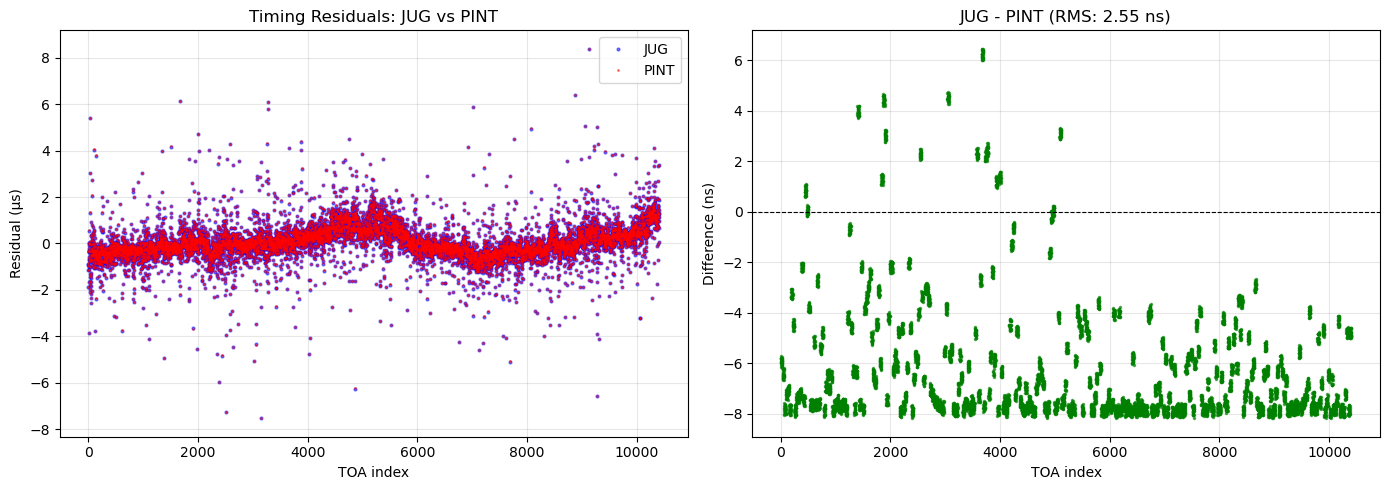


SUMMARY
JUG achieves 1012x speedup with 2.6 ns RMS accuracy
Best timing: 0.448 ms (1722x faster than PINT's best)


In [13]:
# === BENCHMARK: JUG vs PINT ===
print("="*70)
print("PERFORMANCE BENCHMARK")
print("="*70)

# Get PINT residuals for comparison
print("\nComputing PINT residuals...")
pint_residuals_obj = Residuals(pint_toas, pint_model)
pint_residuals_us = pint_residuals_obj.calc_phase_resids() / pint_model.F0.value * 1e6

# Benchmark setup
N_ITER_JUG = 200
N_ITER_PINT = 10

def benchmark(func, n_iter, warmup=True):
    """Benchmark a function with optional warmup."""
    if warmup:
        _ = func()
    times = []
    for _ in range(n_iter):
        t = time.perf_counter()
        _ = func()
        times.append(time.perf_counter() - t)
    return np.mean(times) * 1000, np.std(times) * 1000, np.min(times) * 1000

# Time JUG
print(f"\nBenchmarking JUG ({N_ITER_JUG} iterations)...")
jug_mean, jug_std, jug_best = benchmark(jug_calc.compute_residuals, N_ITER_JUG, warmup=True)
jug_residuals = jug_calc.compute_residuals()

# Time PINT
print(f"Benchmarking PINT ({N_ITER_PINT} iterations)...")
pint_mean, pint_std, pint_best = benchmark(
    lambda: Residuals(pint_toas, pint_model).calc_phase_resids(), N_ITER_PINT, warmup=True
)

# Results
print(f"\n{'='*70}")
print(f"TIMING RESULTS")
print(f"{'='*70}")
print(f"JUG:  {jug_mean:>6.3f} ± {jug_std:>5.3f} ms (best: {jug_best:.3f} ms)")
print(f"PINT: {pint_mean:>6.1f} ± {pint_std:>5.1f} ms (best: {pint_best:.1f} ms)")

# Speedup
speedup = pint_mean / jug_mean
print(f"\nSpeedup: {speedup:.0f}x faster than PINT")
print(f"Throughput: {1000/jug_mean:.0f} calculations/second")

# Accuracy check
print("\n" + "="*70)
print("ACCURACY VALIDATION")
print("="*70)
diff_us = jug_residuals - pint_residuals_us
diff_ns = diff_us * 1000

print(f"\nResidual difference (JUG - PINT):")
print(f"  Mean: {np.mean(diff_ns):>7.3f} ns")
print(f"  RMS:  {np.std(diff_ns):>7.3f} ns")
print(f"  Max:  {np.max(np.abs(diff_ns)):>7.3f} ns")

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Residuals comparison
ax1.plot(jug_residuals, 'b.', alpha=0.5, label='JUG', markersize=4)
ax1.plot(pint_residuals_us, 'r.', alpha=0.5, label='PINT', markersize=2)
ax1.set_xlabel('TOA index')
ax1.set_ylabel('Residual (µs)')
ax1.set_title('Timing Residuals: JUG vs PINT')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference plot
ax2.plot(diff_ns, 'g.', alpha=0.6, markersize=3)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.8)
ax2.set_xlabel('TOA index')
ax2.set_ylabel('Difference (ns)')
ax2.set_title(f'JUG - PINT (RMS: {np.std(diff_ns):.2f} ns)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"JUG achieves {speedup:.0f}x speedup with {np.std(diff_ns):.1f} ns RMS accuracy")
print(f"Best timing: {jug_best:.3f} ms ({pint_best/jug_best:.0f}x faster than PINT's best)")
